In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Configuración de Plotly
pd.options.plotting.backend = "plotly"

print("--- Loading Final Scores Dataset ---")
try:
    # Cargamos el archivo que preparamos para el dashboard
    df_scores = pd.read_csv('../data/iris_scores_for_dashboard.csv')
    print("Scores dataset loaded successfully.")
    print(f"Shape: {df_scores.shape}")
except FileNotFoundError:
    print("ERROR: Scores dataset not found. Please run the feature engineering notebook first.")

--- Loading Final Scores Dataset ---
Scores dataset loaded successfully.
Shape: (2017, 11)


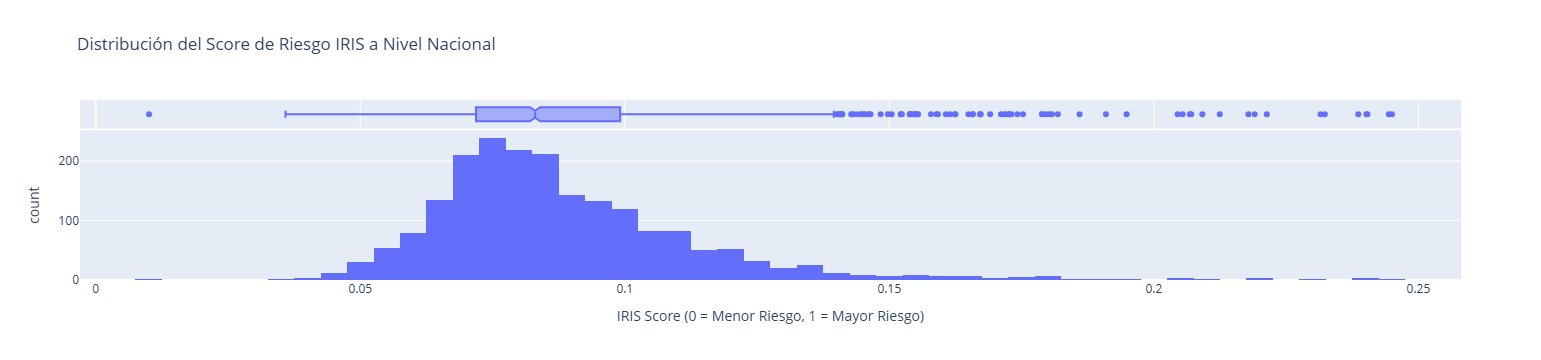


--- Estadísticas Descriptivas del IRIS Score ---


count    2017.000000
mean        0.088194
std         0.025817
min         0.010074
25%         0.071891
50%         0.083033
75%         0.099123
max         0.244993
Name: iris_score, dtype: float64

In [3]:
# --- National Level Analysis: IRIS Score Distribution ---

# Simplemente eliminamos st.header()

fig = px.histogram(
    df_scores,
    x="iris_score",
    title="Distribución del Score de Riesgo IRIS a Nivel Nacional",
    labels={"iris_score": "IRIS Score (0 = Menor Riesgo, 1 = Mayor Riesgo)"},
    nbins=50,
    marginal="box" # Añade un boxplot para ver la mediana y los cuartiles
)
fig.show()

print("\n--- Estadísticas Descriptivas del IRIS Score ---")
display(df_scores['iris_score'].describe())


--- Perfil Promedio de los Sub-Factores por Categoría de Riesgo ---


risk_category,index,Alto Riesgo (Top 10%),Bajo Riesgo (Bottom 10%),Riesgo Medio
0,g_factor_tasa_paralizacion,0.114023,0.010314,0.042631
1,g_factor_ratio_sobretiempo_promedio,0.118199,0.040415,0.051865
2,g_factor_ratio_sobrecosto_promedio,0.018515,0.001036,0.001284
3,s_factor_total_muertes,0.065721,0.002220,0.011821
4,s_factor_edad_prom_muerte,0.547998,0.281231,0.403861
5,s_factor_tasa_prevenibles,0.000000,0.000000,0.000000


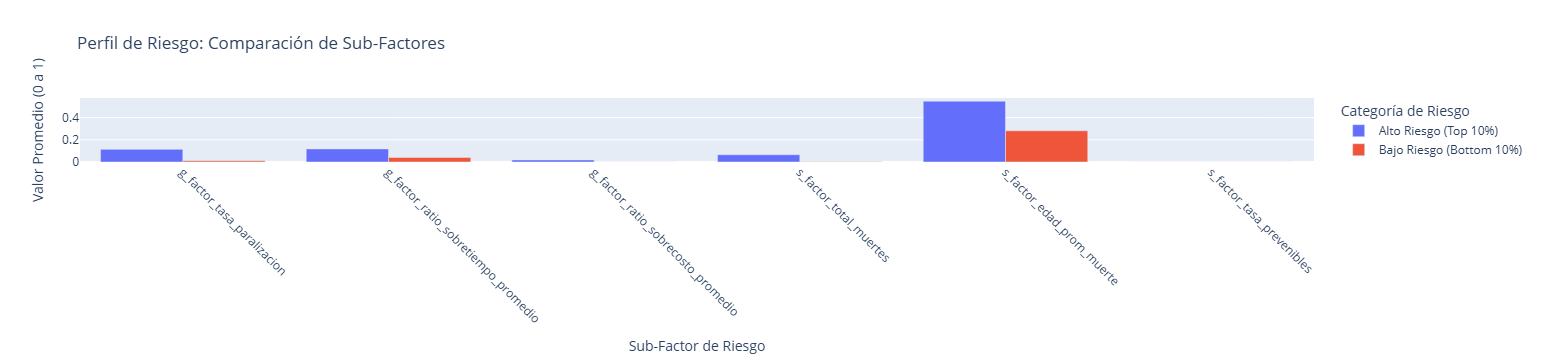

In [9]:
# --- Risk Profiling: What does a "High Risk" district look like? ---

# 1. Creamos categorías de riesgo (sin cambios)
cuantiles = df_scores['iris_score'].quantile([0.1, 0.9]).to_dict()
bajo_riesgo_threshold = cuantiles[0.1]
alto_riesgo_threshold = cuantiles[0.9]

def categorizar_riesgo(score):
    if score >= alto_riesgo_threshold:
        return 'Alto Riesgo (Top 10%)'
    elif score <= bajo_riesgo_threshold:
        return 'Bajo Riesgo (Bottom 10%)'
    else:
        return 'Riesgo Medio'
        
df_scores['risk_category'] = df_scores['iris_score'].apply(categorizar_riesgo)

# 2. Calculamos el perfil promedio (sin cambios)
factor_cols = [col for col in df_scores.columns if '_factor' in col]
perfil_riesgo = df_scores.groupby('risk_category')[factor_cols].mean().T.reset_index()

print("\n--- Perfil Promedio de los Sub-Factores por Categoría de Riesgo ---")
display(perfil_riesgo)


# 3. Preparamos los datos para la visualización
# Derretimos el DataFrame para tener un formato "largo"
df_plot = perfil_riesgo.melt(
    id_vars='index', 
    value_vars=['Alto Riesgo (Top 10%)', 'Bajo Riesgo (Bottom 10%)'],
    var_name='risk_category', # ¡LE DAMOS UN NOMBRE EXPLÍCITO A LA NUEVA COLUMNA!
    value_name='Valor Promedio (Normalizado)'
)


# 4. Visualizamos el perfil
fig = px.bar(
    df_plot,
    x='index', # La columna con los nombres de los factores
    y='Valor Promedio (Normalizado)',
    color='risk_category', # Ahora usamos este nombre, que sabemos que es correcto
    barmode='group',
    title='Perfil de Riesgo: Comparación de Sub-Factores',
    labels={
        'index': 'Sub-Factor de Riesgo', 
        'Valor Promedio (Normalizado)': 'Valor Promedio (0 a 1)', 
        'risk_category': 'Categoría de Riesgo'
    }
)
fig.update_xaxes(tickangle=45)
fig.show()

In [10]:
# --- Análisis Adicional 1: Identificación de "Puntos Calientes" de Riesgo ---

print("--- Identificando Distritos 'Outlier' de Alto Riesgo (Método IQR) ---\n")

# 1. Calculamos los cuartiles y el Rango Intercuartílico (IQR)
Q1 = df_scores['iris_score'].quantile(0.25)
Q3 = df_scores['iris_score'].quantile(0.75)
IQR = Q3 - Q1

# 2. Definimos el umbral para un outlier de alto riesgo
#    La definición estándar es cualquier punto por encima de Q3 + 1.5 * IQR
outlier_threshold = Q3 + 1.5 * IQR

print(f"Umbral del  cuantitativo (Q3): {Q3:.4f}")
print(f"Rango Intercuartílico (IQR): {IQR:.4f}")
print(f"Umbral para 'Outlier de Alto Riesgo' (Q3 + 1.5*IQR): {outlier_threshold:.4f}\n")

# 3. Filtramos para encontrar los distritos que superan este umbral
df_hotspots = df_scores[df_scores['iris_score'] > outlier_threshold].sort_values(by='iris_score', ascending=False)

print(f"Se han identificado {len(df_hotspots)} distritos como 'Puntos Calientes' de riesgo estadístico.")
print("Estos son los distritos con el riesgo más anómalo y extremo del país:\n")

# Mostramos los resultados, enfocándonos en los scores
display(df_hotspots[['ubigeo', 'iris_score', 'g_score', 's_score']])

--- Identificando Distritos 'Outlier' de Alto Riesgo (Método IQR) ---

Umbral del  cuantitativo (Q3): 0.0991
Rango Intercuartílico (IQR): 0.0272
Umbral para 'Outlier de Alto Riesgo' (Q3 + 1.5*IQR): 0.1400

Se han identificado 76 distritos como 'Puntos Calientes' de riesgo estadístico.
Estos son los distritos con el riesgo más anómalo y extremo del país:



,ubigeo,iris_score,g_score,s_score
1514,LIMA_LIMA_SAN JUAN DE LURIGANCHO,0.244993,0.016134,0.473853
1738,PIURA_PIURA_LA ARENA,0.244405,0.336182,0.152628
621,CAJAMARCA_CELENDIN_OXAMARCA,0.240367,0.345965,0.134769
229,ANCASH_RECUAY_ACCOMARCA,0.240154,0.348123,0.132185
984,HUANCAVELICA_TAYACAJA_DANIEL ALOMIA ROBLES,0.238635,0.345085,0.132185
...,...,...,...,...
41,AMAZONAS_CONDORCANQUI_RIO SANTIAGO,0.141037,0.021633,0.260441
804,CUSCO_LA CONVENCION_PICHARI,0.140819,0.049907,0.231730
597,CAJAMARCA_CAJABAMBA_CACHACHI,0.140767,0.118161,0.163373
1789,PUNO_CARABAYA_SAN GABAN,0.140445,0.039873,0.241018


--- Clasificando Distritos en Arquetipos de Riesgo ---

Distribución de Distritos por Arquetipo de Riesgo:


risk_archetype
Bajo Riesgo General                                 559
Riesgo Híbrido (Problemas de Gestión y Sociales)    529
Riesgo de Gestión (Socialmente Estable)             479
Riesgo Social (Gestión Eficiente)                   450
Name: count, dtype: int64

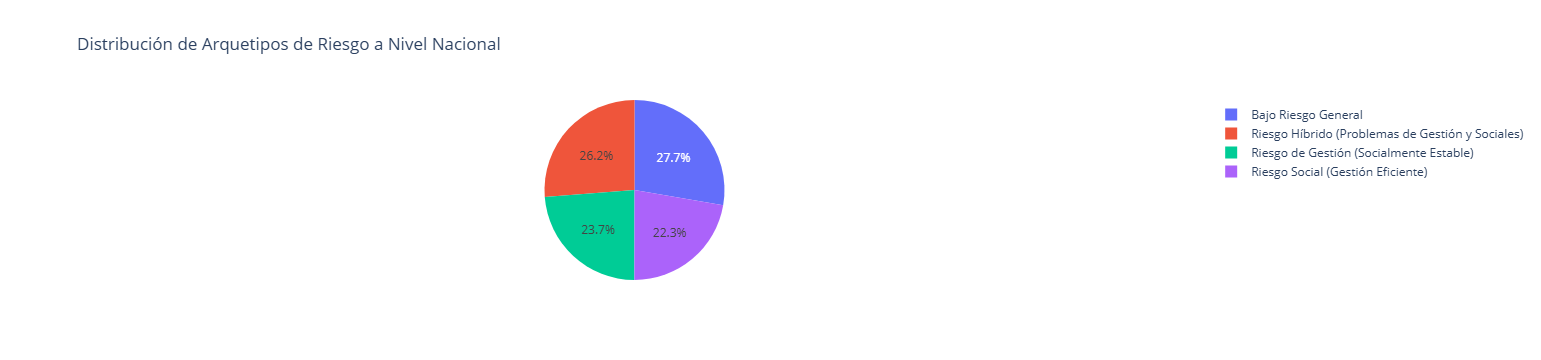

In [11]:
# --- Análisis Adicional 2: Segmentación por Arquetipos de Riesgo ---

print("--- Clasificando Distritos en Arquetipos de Riesgo ---\n")

# 1. Calculamos las medianas nacionales para G-Score y S-Score
median_g_score = df_scores['g_score'].median()
median_s_score = df_scores['s_score'].median()

# 2. Definimos la función para asignar el arquetipo
def asignar_arquetipo(row):
    g_alto = row['g_score'] > median_g_score
    s_alto = row['s_score'] > median_s_score
    
    if g_alto and s_alto:
        return "Riesgo Híbrido (Problemas de Gestión y Sociales)"
    elif g_alto and not s_alto:
        return "Riesgo de Gestión (Socialmente Estable)"
    elif not g_alto and s_alto:
        return "Riesgo Social (Gestión Eficiente)"
    else:
        return "Bajo Riesgo General"

# 3. Aplicamos la función para crear la nueva columna
df_scores['risk_archetype'] = df_scores.apply(asignar_arquetipo, axis=1)

# 4. Analizamos la distribución de los arquetipos
conteo_arquetipos = df_scores['risk_archetype'].value_counts()

print("Distribución de Distritos por Arquetipo de Riesgo:")
display(conteo_arquetipos)

# 5. Visualizamos la distribución en un gráfico de "pastel" (pie chart)
fig = px.pie(
    conteo_arquetipos, 
    values=conteo_arquetipos.values, 
    names=conteo_arquetipos.index,
    title='Distribución de Arquetipos de Riesgo a Nivel Nacional'
)
fig.show()

--- Analizando la Correlación entre Sub-Factores y el Score IRIS Final ---

Correlación de cada componente con el Score IRIS final:


,iris_score
iris_score,1.000000
s_score,0.748612
g_score,0.664752
s_factor_edad_prom_muerte,0.656337
g_factor_tasa_paralizacion,0.451584
g_factor_ratio_sobretiempo_promedio,0.444782
s_factor_total_muertes,0.343083
g_factor_ratio_sobrecosto_promedio,0.217832
s_factor_tasa_prevenibles,NaN


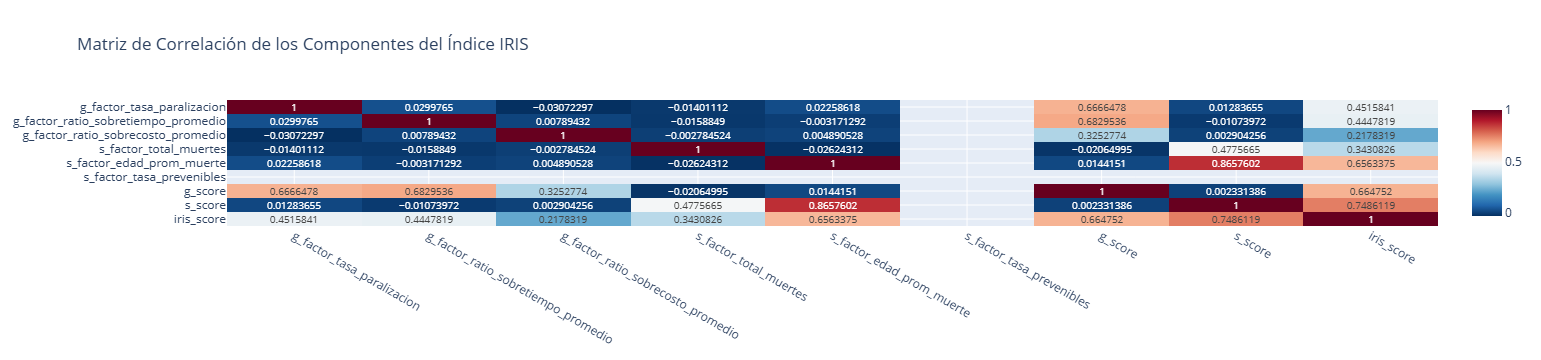

In [12]:
# --- Análisis Adicional 3: Motores del Riesgo (Correlación de Sub-Factores) ---

print("--- Analizando la Correlación entre Sub-Factores y el Score IRIS Final ---\n")

# 1. Seleccionamos solo las columnas de factores y el score final
factor_cols_for_corr = [col for col in df_scores.columns if '_factor' in col or '_score' in col]
df_corr = df_scores[factor_cols_for_corr]

# 2. Calculamos la matriz de correlación
correlation_matrix = df_corr.corr()

# 3. Aislamos la correlación de cada factor con el 'iris_score'
corr_con_iris = correlation_matrix[['iris_score']].sort_values(by='iris_score', ascending=False)

print("Correlación de cada componente con el Score IRIS final:")
display(corr_con_iris)

# 4. Visualizamos la matriz completa como un mapa de calor
fig = px.imshow(
    correlation_matrix,
    text_auto=True, # Muestra los números dentro de las celdas
    aspect="auto",
    color_continuous_scale='RdBu_r', # Rojo para positivo, Azul para negativo
    title='Matriz de Correlación de los Componentes del Índice IRIS'
)
fig.show()

In [13]:
# --- ANÁLISIS TEXTUAL AVANZADO DEL ÍNDICE IRIS ---

# Asegurémonos de que las columnas 'risk_archetype' y 'risk_category' existan
# Si no existen, las creamos aquí (el código es idempotente)
if 'risk_category' not in df_scores.columns:
    cuantiles = df_scores['iris_score'].quantile([0.1, 0.9]).to_dict()
    bajo_riesgo_threshold = cuantiles[0.1]
    alto_riesgo_threshold = cuantiles[0.9]
    def categorizar_riesgo(score):
        if score >= alto_riesgo_threshold: return 'Alto Riesgo (Top 10%)'
        elif score <= bajo_riesgo_threshold: return 'Bajo Riesgo (Bottom 10%)'
        else: return 'Riesgo Medio'
    df_scores['risk_category'] = df_scores['iris_score'].apply(categorizar_riesgo)

if 'risk_archetype' not in df_scores.columns:
    median_g_score = df_scores['g_score'].median()
    median_s_score = df_scores['s_score'].median()
    def asignar_arquetipo(row):
        g_alto = row['g_score'] > median_g_score
        s_alto = row['s_score'] > median_s_score
        if g_alto and s_alto: return "Riesgo Híbrido"
        elif g_alto and not s_alto: return "Riesgo de Gestión"
        elif not g_alto and s_alto: return "Riesgo Social"
        else: return "Bajo Riesgo General"
    df_scores['risk_archetype'] = df_scores.apply(asignar_arquetipo, axis=1)


# --- INICIO DEL INFORME ---
print("==========================================================")
print("  INFORME DE ANÁLISIS AVANZADO DEL ÍNDICE DE RIESGO IRIS")
print("==========================================================")

# --- Sección 1: Perfil General del Riesgo ---
total_distritos = len(df_scores)
mean_score = df_scores['iris_score'].mean()
median_score = df_scores['iris_score'].median()
std_dev_score = df_scores['iris_score'].std()

print(f"\n1. PERFIL GENERAL DEL RIESGO (N={total_distritos:,} Distritos)")
print("----------------------------------------------------------")
print(f"El score de riesgo IRIS promedio a nivel nacional es de {mean_score:.4f}, con una mediana de {median_score:.4f}.")
print(f"La desviación estándar de {std_dev_score:.4f} indica una dispersión moderada del riesgo entre los distritos.")

# --- Sección 2: Los Motores del Riesgo (Correlación) ---
factor_cols_for_corr = [col for col in df_scores.columns if '_factor' in col or '_score' in col]
df_corr = df_scores[factor_cols_for_corr]
correlation_matrix = df_corr.corr()
corr_con_iris = correlation_matrix[['iris_score']].sort_values(by='iris_score', ascending=False)
principal_motor = corr_con_iris.index[1] # El [0] es el iris_score mismo
corr_principal = corr_con_iris.iloc[1,0]
motor_secundario = corr_con_iris.index[2]
corr_secundaria = corr_con_iris.iloc[2,0]
subfactor_principal = corr_con_iris.index[3]
corr_subfactor = corr_con_iris.iloc[3,0]

print(f"\n2. LOS MOTORES DEL RIESGO (Análisis de Correlación)")
print("----------------------------------------------------------")
print(f"El principal impulsor del índice IRIS es el '{principal_motor}' (Correlación: {corr_principal:.2f}), "
      f"seguido de cerca por el '{motor_secundario}' (Correlación: {corr_secundaria:.2f}).")
print(f"A nivel de sub-factor individual, la señal más potente es '{subfactor_principal}' (Correlación: {corr_subfactor:.2f}).")
print("Esto valida la hipótesis de que tanto los factores sociales como los de gestión son componentes cruciales del riesgo, "
      "con una ligera preponderancia del componente social.")


# --- Sección 3: Tipología del Riesgo (Arquetipos) ---
conteo_arquetipos = df_scores['risk_archetype'].value_counts(normalize=True) * 100
arquetipo_dominante = conteo_arquetipos.index[0]
porc_dominante = conteo_arquetipos.iloc[0]

print(f"\n3. TIPOLOGÍA DEL RIESGO (Segmentación por Arquetipos)")
print("----------------------------------------------------------")
print("La distribución del riesgo no es monolítica. Los distritos se distribuyen de manera relativamente uniforme en cuatro perfiles:")
for arquetipo, porcentaje in conteo_arquetipos.items():
    print(f"  - {arquetipo:<20}: {porcentaje:.1f}%")
print(f"El arquetipo más común es '{arquetipo_dominante}', representando al {porc_dominante:.1f}% de los distritos.")
print("Esto demuestra la necesidad de un índice compuesto para capturar la naturaleza multifactorial del riesgo.")


# --- Sección 4: Concentración del Riesgo (Puntos Calientes) ---
Q1 = df_scores['iris_score'].quantile(0.25)
Q3 = df_scores['iris_score'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
df_hotspots = df_scores[df_scores['iris_score'] > outlier_threshold]
num_hotspots = len(df_hotspots)
porc_hotspots = (num_hotspots / total_distritos) * 100

print(f"\n4. CONCENTRACIÓN DEL RIESGO (Análisis de Outliers)")
print("----------------------------------------------------------")
print(f"Se ha definido un umbral estadístico de 'riesgo extremo' en un score IRIS de {outlier_threshold:.4f}.")
print(f"Un total de {num_hotspots} distritos superan este umbral, siendo clasificados como 'Puntos Calientes'.")
print(f"Esto significa que el riesgo más anómalo del país está altamente concentrado en solo el {porc_hotspots:.1f}% de los distritos.")
print("Estos 76 'Puntos Calientes' representan el principal resultado accionable del Proyecto IRIS.")
print("==========================================================")

  INFORME DE ANÁLISIS AVANZADO DEL ÍNDICE DE RIESGO IRIS

1. PERFIL GENERAL DEL RIESGO (N=2,017 Distritos)
----------------------------------------------------------
El score de riesgo IRIS promedio a nivel nacional es de 0.0882, con una mediana de 0.0830.
La desviación estándar de 0.0258 indica una dispersión moderada del riesgo entre los distritos.

2. LOS MOTORES DEL RIESGO (Análisis de Correlación)
----------------------------------------------------------
El principal impulsor del índice IRIS es el 's_score' (Correlación: 0.75), seguido de cerca por el 'g_score' (Correlación: 0.66).
A nivel de sub-factor individual, la señal más potente es 's_factor_edad_prom_muerte' (Correlación: 0.66).
Esto valida la hipótesis de que tanto los factores sociales como los de gestión son componentes cruciales del riesgo, con una ligera preponderancia del componente social.

3. TIPOLOGÍA DEL RIESGO (Segmentación por Arquetipos)
----------------------------------------------------------
La distribuci